# Network Science: Assignment 4
Learning Team 5 | MSDS2021  
Carpio, Dolorso, Madrigal, Mendez.

#### Libraries

In [1]:
## For Network Analysis and Visualization
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import operator
import warnings
import pandas as pd
import seaborn as sns

## For Hierarchical Clustering
from scipy.cluster import hierarchy
from scipy.spatial import distance

## For Community Detection (Louvain Method)
import community
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def connected_nodes(names, source=True, target=True):
    """Returns the nodes connected to specified nodes."""
    
    res = []
    
    if type(names) == str:
        names = [names]
        
    if source:
        res += list(edges[edges['Source'].isin(names)]['Target'])
    if target:
        res += list(edges[edges['Target'].isin(names)]['Source'])
        
    return res

### 1. Load the social network provided here.

In [3]:
try: 
    from google.colab import drive
    drive.mount('/content/drive')
    nodes = pd.read_csv('/content/drive/MyDrive/CPT/96 Non-CPT stuff/NS Assignment 4/social_network_nodes.csv')
    edges = pd.read_csv('/content/drive/MyDrive/CPT/96 Non-CPT stuff/NS Assignment 4/social_network_edges.csv')
except:
    nodes = pd.read_csv('social_network_nodes.csv')
    edges = pd.read_csv('social_network_edges.csv')

display(nodes.head())
display(edges.head())

,Name,Historical Role,Gender,Birth Year,Death Year
0,Robert Tanner,religious writer,male,1663,1731
1,Willie Schlater,local politician and author,male,1621,1694
2,Dan Jimenez,colonial official and scholar,male,1674,1751
3,Particia Turner,Community pastor,female,1656,1659
4,Thomas Boudreau,Community pastor and poet,male,1626,1697


,Source,Target
0,Antonio Rutledge,Daniel Lopez
1,Antonio Rutledge,Jeffrey Jackson
2,Antonio Rutledge,Lieselotte Egan
3,Antonio Rutledge,Eric Hebb
4,Antonio Rutledge,James Cooks


### 2. Build the network including all node attributes. 

In [4]:
# Build Graph
G = nx.Graph()
G.add_nodes_from(nodes['Name'])
for x in edges.values:
    G.add_edge(x[0], x[1])
    
# Add attributes
nx.set_node_attributes(G, nodes.set_index('Name').to_dict('index'))

# Giant Component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

# Sanity Check
Person = 'Robert Tanner'
display(nodes[nodes.Name == Person])
print('Node attributes:')
print(nx.get_node_attributes(G, "Historical Role")[Person], 
      nx.get_node_attributes(G, "Gender")[Person], 
      nx.get_node_attributes(G, "Birth Year")[Person], 
      nx.get_node_attributes(G, "Death Year")[Person])

,Name,Historical Role,Gender,Birth Year,Death Year
0,Robert Tanner,religious writer,male,1663,1731


Node attributes:
religious writer male 1663 1731


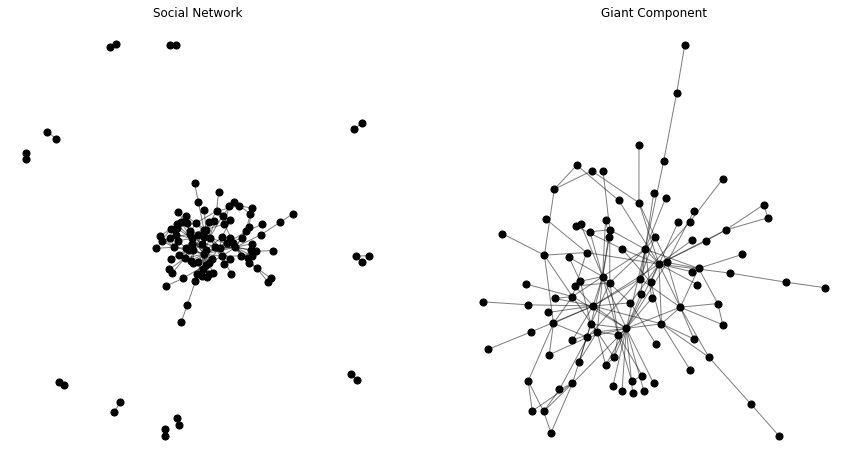

In [5]:
pos = nx.fruchterman_reingold_layout(G)
pos0 = nx.spring_layout(G0)

fig, ax = plt.subplots(ncols=2, figsize=(15,8));

# Entire Network
nx.draw_networkx_nodes(G, pos, cmap='viridis', node_size=50,
                       node_color='black', ax=ax[0])
nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax[0])

# Giant Component
nx.draw_networkx_nodes(G0, pos0, cmap='viridis', node_size=50,
                       node_color='black', ax=ax[1])
nx.draw_networkx_edges(G0, pos0, alpha=0.5, ax=ax[1])

ax[0].set_title('Social Network')
ax[1].set_title('Giant Component')
ax[0].axis("off")
ax[1].axis("off");

### 3. Describe some of the relevant properties of the network.

#### Nodes EDA

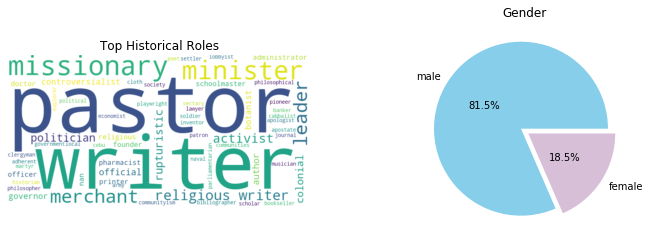

In [6]:
df_gender = pd.DataFrame(dict(Counter(nodes['Gender'])), index=['Count']).T
labels = df_gender.index
exclude = ['community', 'philippines']
roles = ' '.join([str(x).lower() for x in nodes['Historical Role']])
roles = ' '.join([x for x in roles.split(' ') if x not in exclude])

wc = WordCloud(background_color="white", max_words=100, 
               random_state=2, width=800, height=400)
wc.generate(roles)

fig, ax = plt.subplots(ncols=2, figsize=[12,4])
ax[0].set_title('Top Historical Roles');
ax[0].imshow(wc, interpolation="bilinear")
ax[0].axis('off')

ax[1].set_title('Gender');
ax[1].pie(x=df_gender, autopct="%.1f%%", explode=[0.05]*2, 
        labels=labels, pctdistance=0.5, colors=['skyblue', 'thistle'])

sns.despine();

Looking at the nodes we're working with, most of the nodes have a role of `pastor`, `writer`, and/or `missionary`, providing a clue that the social network has a **religious** nature. We can also see that majority in the network are male (81.5%) and only 18.5% are female.

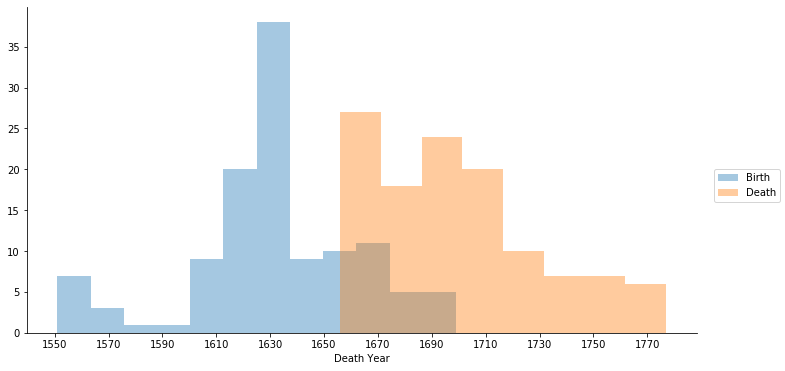

In [7]:
fig = plt.figure(figsize=(12,6))
ax = sns.distplot(nodes['Birth Year'], kde=False)
ax = sns.distplot(nodes['Death Year'], kde=False)
fig.legend(labels=['Birth', 'Death'], loc='right')
ax.set_xticks(range(1550, 1780, 20))
sns.despine();

In terms of lifespan, the social network existed from 1500-1700s with most born around 1630s.

#### Real-world Partition (Gender)

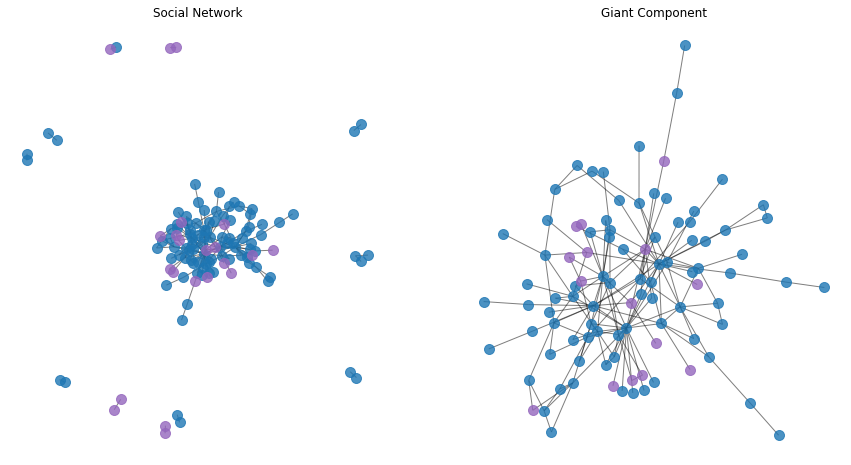

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(15,8));

nodes0 = nodes[nodes.Name.isin(G0.nodes)]

nx.draw_networkx_nodes(G, pos, nodelist=nodes[nodes['Gender']=='male'].Name,
                       node_color='tab:blue', node_size=100, alpha=0.8, 
                       ax=ax[0])
nx.draw_networkx_nodes(G, pos,
                       nodelist=nodes[nodes['Gender']=='female'].Name,
                       node_color='tab:purple',
                       node_size=100,
                       alpha=0.8, ax=ax[0])
nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax[0])

nx.draw_networkx_nodes(G0, pos0, 
                       nodelist=nodes0[nodes0['Gender']=='male'].Name,
                       node_color='tab:blue',
                       node_size=100, alpha=0.8, ax=ax[1]);
nx.draw_networkx_nodes(G0, pos0,
                       nodelist=nodes0[nodes0['Gender']=='female'].Name,
                       node_color='tab:purple',
                       node_size=100,
                   alpha=0.8, ax=ax[1]);
nx.draw_networkx_edges(G0, pos0, alpha=0.5, ax=ax[1]);

ax[0].set_title('Social Network')
ax[1].set_title('Giant Component')
ax[0].axis("off")
ax[1].axis("off");

Using gender as a real-world partition does not produce comprehensive partition results in both the entire social network and the giant component. This may also be due to the imbalance as mentioned earlier.

#### Communities

Entire Network: 19 partitions
Giant Component: 8 partitions


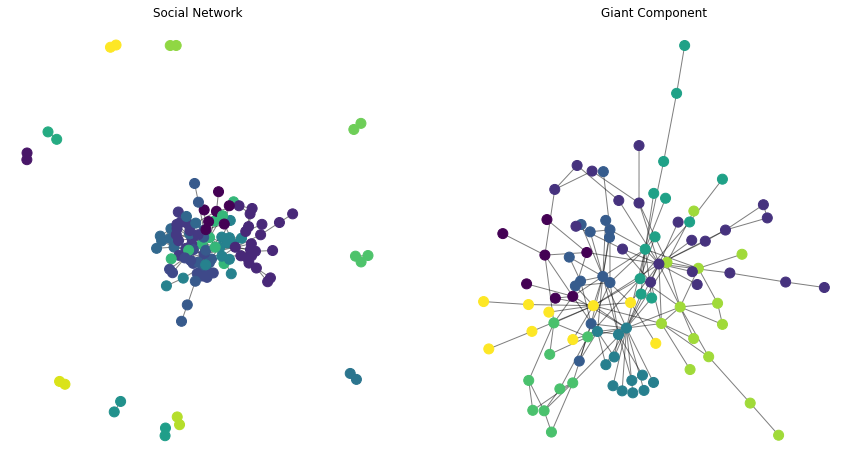

In [9]:
partition = community.best_partition(G)
partition0 = community.best_partition(G0)

print(f'Entire Network: {len(set(partition.values()))} partitions')
print(f'Giant Component: {len(set(partition0.values()))} partitions')


fig, ax = plt.subplots(ncols=2, figsize=(15,8));

nodes0 = nodes[nodes.Name.isin(G0.nodes)]

# Entire Network
nx.draw_networkx_nodes(G, pos, cmap='viridis', node_size=100,
                       node_color=list(partition.values()), ax=ax[0])
nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax[0])

# Giant Component
nx.draw_networkx_nodes(G0, pos0, cmap='viridis', node_size=100,
                       node_color=list(partition0.values()), ax=ax[1])
nx.draw_networkx_edges(G0, pos0, alpha=0.5, ax=ax[1])

ax[0].set_title('Social Network')
ax[1].set_title('Giant Component')
ax[0].axis("off")
ax[1].axis("off");

Modularity-based Community Detection identifies 19 partitions/community in the entire network and 8 for the Giant component — but the resulting network seems trivial.

#### Centrality

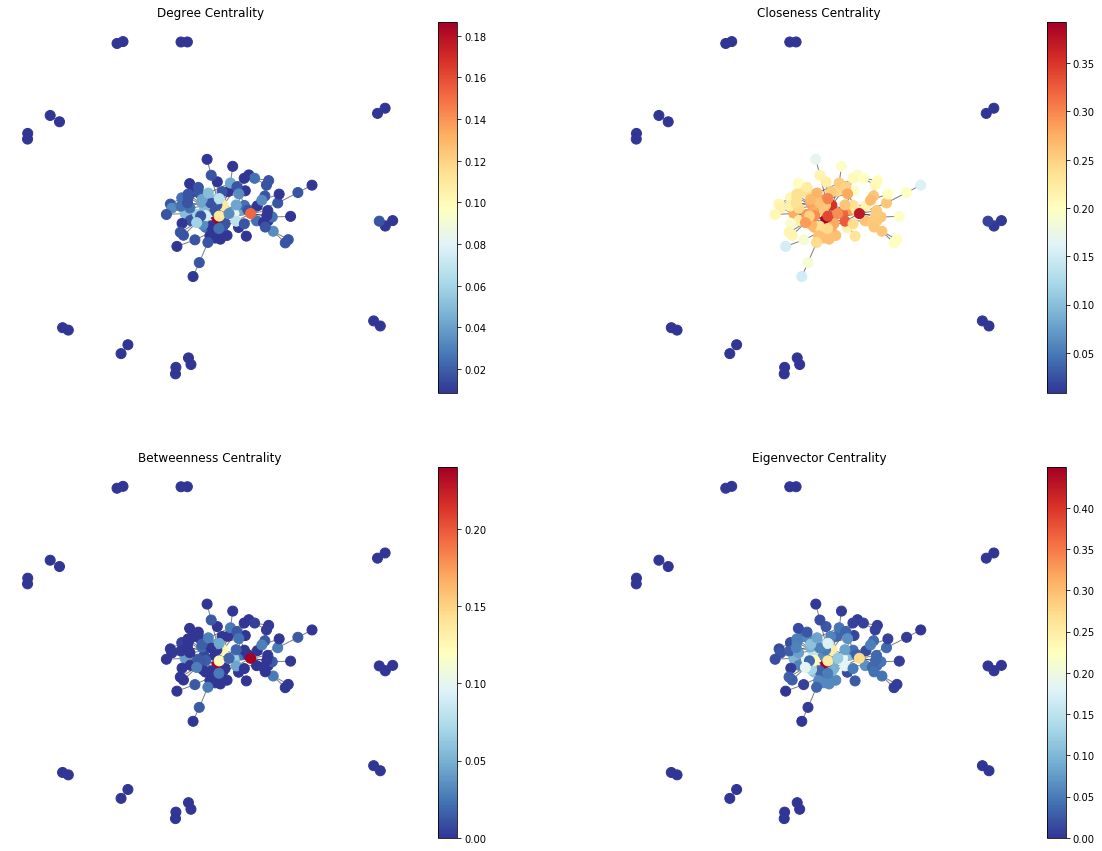

In [10]:
nodes['Degree'] = nx.degree_centrality(G).values()
nodes['Closeness'] = nx.closeness_centrality(G).values()
nodes['Betweenness'] = nx.betweenness_centrality(G).values()
nodes['Eigenvector'] = nx.eigenvector_centrality(G).values()

fig = plt.figure(figsize=(20,15));
centralities = nodes.iloc[:,-4:].to_numpy().T
titles = ['Degree Centrality', 'Closeness Centrality', 
          'Betweenness Centrality', 'Eigenvector Centrality']

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1);
    nc = nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.RdYlBu_r,
                            node_color=centralities[i]);
    nx.draw_networkx_edges(G, pos, alpha=0.500);
    plt.title(titles[i]);
    plt.axis('off');
    plt.colorbar(nc);

plt.show();

#### Summary

In [12]:
pd.DataFrame({
    'Nodes': [G.order(), G0.order()],
    'Edges': [G.size(), G0.size()],
    'Communities': [len(set(partition.values())), 
                    len(set(partition0.values()))]}, 
    index=['Entire Network', 'Giant Component'])

,Nodes,Edges,Communities
Entire Network,119,174,19
Giant Component,96,162,8


### 4. Can you provide some insights on the potential dynamics of the system given the network properties?

### 5. What conclusions can you draw from the social network? Craft a narrative.